# Deep Ensemble learning: Stacking results from deep learning models

# Outline
* **1. Introduction**

    * 1.1 Loading Libraries

* **2. Data preparation**

    * 2.1 Load Data, Metadata, and Preprocess for Each Model
    
    * 2.2 Exploratory Data Analysis
    
    * 2.3 Feature Extraction

* **3. Training & Validating**

    * 3.1 Split Test/Valid dataset
    
    * 3.2 Classifiers
    
    * 3.3 Models Evaluation
    
    * 3.4 Ensemble models

* **4. Testing model's performance**

    * 4.1 Confusion Matrix and Precision-Recall
    
    * 4.2 Results Summary

# **1. Introduction**


### This code is specifically written for [GRAB AI for S.E.A challenge](https://www.aiforsea.com/).

This is a full walkthrough for building the ensemble learning model for car image dataset provided by [AI Stanford University](https://ai.stanford.edu/~jkrause/cars/car_dataset.html). For this competition, I implemented stacked ensemble machine learning, which the outputs from 5 well-known Deep Learning architectures (Inception, Xception, Resnet50, VGG19, and InceptionResnet) are stacked together and used it as the input for new neural networks. You can check more info about stacked ensemble machine learning [HERE](https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/). First, I will prepare the data (Car images), get prediction for each models (InceptionV3, Xception, VGG, Xception, and InceptionResnet), and combine each results from the model and feed the output as an input into final neural networks model.

Special thanks to Hyungsuk Kang from Kaggle for his [Kernel](https://www.kaggle.com/sudosudoohio/eda-deep-learning-ensemble/data) which I adopted some of his code into this code (of course with adjustments).

## 1.1 Loading Libraries

In this comppetition, I used Keras with Tensorflow backend.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from tqdm import tqdm
from keras.models import Model, Sequential
from keras.layers import Input, GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Dropout, Lambda, Reshape, Flatten
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
import cv2
from keras.applications.inception_v3 import preprocess_input as inception_v3_pre
from keras.applications.resnet50 import preprocess_input as resnet50_pre
from keras.applications.vgg19 import preprocess_input as vgg19_pre
from keras.applications.xception import preprocess_input as xception_pre
from keras.applications.inception_resnet_v2 import preprocess_input as InceptionResNetV2_pre
from keras.models import load_model

import matplotlib.image as mpimg
import seaborn as sns
from scipy.io import loadmat
np.random.seed(2)

Using TensorFlow backend.


# 2. Data Preparation

## 2.1. Load Data, Metadata, and Preprocess data for Each Model

Each model requires certain image pixel size and  image diferent preprocesses

### Set up file links and metadata

In [2]:
# Setup Input folder link and image sizes
from pathlib import Path

folder = 'input/'
devkit_path = Path(folder + 'devkit/')
cars_meta = loadmat(devkit_path/'cars_meta.mat')
train_path = folder + 'cars_train/'
cars_train_annos = loadmat(devkit_path/'cars_train_annos.mat')
test_path = folder + 'cars_test/'
cars_test_annos = loadmat(devkit_path/'cars_test_annos_withlabels.mat')

img_path = folder
im_width = 299
im_heigth = 299
im_chan = 3

In [3]:
# Retreiving Class ids and names

frame1 = [[i.flat[0] for i in line] for line in cars_meta['class_names'][0]]
columns1 = ['names']
df_train1 = pd.DataFrame(frame1, columns=columns1)
df_train1.head()
df_train1.tail()

,names
191,Volkswagen Beetle Hatchback 2012
192,Volvo C30 Hatchback 2012
193,Volvo 240 Sedan 1993
194,Volvo XC90 SUV 2007
195,smart fortwo Convertible 2012


### Set up metadata for Training set

In [4]:
# Setup Train set dataframe of metadata with necessary information. Since this code focus on classification, the bounding boxes are excluded.

class_id = []

frame = [[i.flat[0] for i in line] for line in cars_train_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class_id', 'fname']
df_train = pd.DataFrame(frame, columns=columns)
df_train['class_id'] = df_train['class_id']-1 # Python indexing starts on zero.
df_train['fname'] = [train_path + f for f in df_train['fname']] #  Appending Path

for i in range (len(df_train['class_id'])):
    f = df_train['class_id'][i]
    class_id.append(df_train1['names'][f])


df_train['class_name'] = [class_id][0]
df_train = df_train.drop(['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2'], axis = 1) ## Deleting unnecessary infomations
df_train.head()

,class_id,fname,class_name
0,13,input/cars_train/00001.jpg,Audi TTS Coupe 2012
1,2,input/cars_train/00002.jpg,Acura TL Sedan 2012
2,90,input/cars_train/00003.jpg,Dodge Dakota Club Cab 2007
3,133,input/cars_train/00004.jpg,Hyundai Sonata Hybrid Sedan 2012
4,105,input/cars_train/00005.jpg,Ford F-450 Super Duty Crew Cab 2012


### Set up metadata for Test set

In [5]:
class_id1 = []

frame = [[i.flat[0] for i in line] for line in cars_test_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class_id', 'fname']
df_test = pd.DataFrame(frame, columns=columns)
df_test['class_id'] = df_test['class_id']-1 # Python indexing starts on zero.
df_test['fname'] = [test_path + f for f in df_test['fname']] #  Appending Path

for i in range (len(df_test['class_id'])):
    f = df_test['class_id'][i]
    class_id1.append(df_train1['names'][f])


df_test['class_name'] = [class_id1][0]
df_test = df_test.drop(['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2'], axis = 1) ## Deleting unnecessary infomations
df_test.head()

,class_id,fname,class_name
0,180,input/cars_test/00001.jpg,Suzuki Aerio Sedan 2007
1,102,input/cars_test/00002.jpg,Ferrari 458 Italia Convertible 2012
2,144,input/cars_test/00003.jpg,Jeep Patriot SUV 2012
3,186,input/cars_test/00004.jpg,Toyota Camry Sedan 2012
4,184,input/cars_test/00005.jpg,Tesla Model S Sedan 2012


### Load Training Images

In [6]:
from keras_tqdm import TQDMCallback, TQDMNotebookCallback
from tqdm import tqdm_notebook , tnrange
from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img
from skimage.transform import resize

In [7]:
x_imgs = np.zeros((len(df_train), im_heigth, im_width, im_chan), dtype=np.uint8)
y_imgs = np.zeros((len(df_train), 1), dtype=np.uint8)

for n, id_ in tqdm_notebook(enumerate(df_train['fname']), total=len(df_train['fname'])):
    imgs = load_img(df_train['fname'][n])
    imgs = img_to_array(imgs)
    imgs = resize(imgs, (im_width, im_heigth, im_chan), mode='constant', preserve_range=True, anti_aliasing=True)
    x_imgs[n] = imgs
    
    y_imgs[n] = np.int(df_train['class_id'][n])

## Checking if we load the right data.

In [8]:
def get_images(length, df, imgs):

    rand= np.random.randint(0,length,4)

    fig=plt.figure(figsize=(15, 15))
    columns = 2
    rows = 2
    for i in range(1, columns*rows +1):
        r = rand[i-1]
        img = imgs[r]
        cla_name = df['class_name'][r]
        fig.add_subplot(rows, columns, i)
        plt.title(cla_name)
        plt.imshow(img)

    plt.show()

### Displaying random Train images

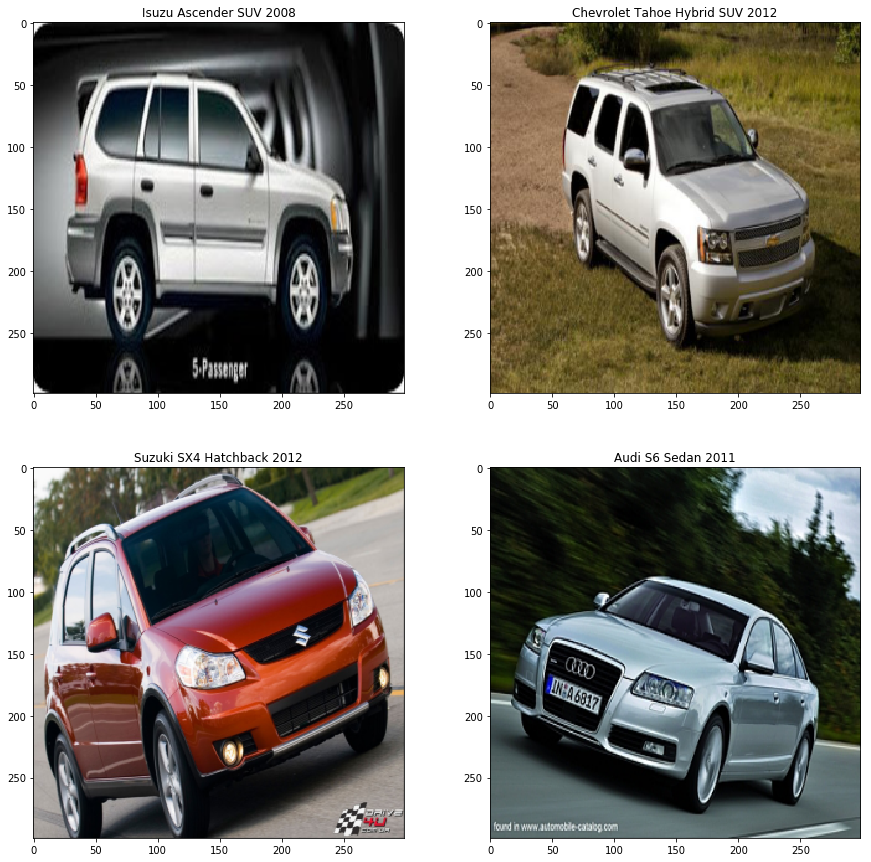

In [9]:
len_train = x_imgs.shape[0]
get_images(len_train, df_train, x_imgs)

### Load Test Images

In [10]:
x_imgs1 = np.zeros((len(df_test), im_heigth, im_width, im_chan), dtype=np.uint8)
y_imgs1 = np.zeros((len(df_test), 1), dtype=np.uint8)

for n, id_ in tqdm_notebook(enumerate(df_test['fname']), total=len(df_test['fname'])):
    imgs1 = load_img(df_test['fname'][n])
    imgs1 = img_to_array(imgs1)
    imgs1 = resize(imgs1, (im_width, im_heigth, im_chan), mode='constant', preserve_range=True, anti_aliasing=True)
    x_imgs1[n] = imgs1
    
    y_imgs1[n] = np.int(df_test['class_id'][n])

In [11]:
print("test set x shape :", x_imgs1.shape)
print("test set y shape :", y_imgs1.shape)

test set x shape : (8041, 299, 299, 3)
test set y shape : (8041, 1)


### Displaying random Test images

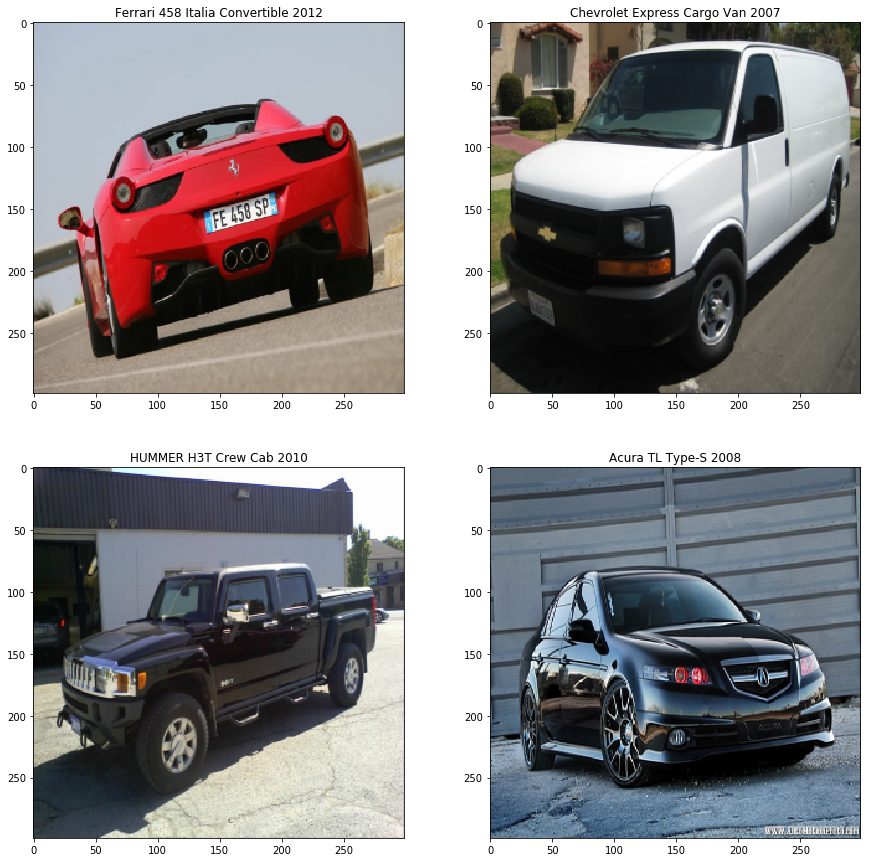

In [12]:
len_test = x_imgs1.shape[0]
get_images(len_test, df_test, x_imgs1)

#### Splitting the test data for validation and testing with ratio 40:60

In [13]:
x_valid, x_test, y_valid, y_test =  train_test_split(x_imgs1, df_test['class_id'], test_size=0.6, random_state=99)

## 2.2 Exploratory Data Analysis

### Distribution of Output Variable

In [14]:
# Checking the class frequency

freq_labels = df_train.groupby('class_name').count()[['class_id']]
freq_labels = freq_labels.rename(columns={'class': 'count'})
freq_labels = freq_labels.sort_values(by='class_id', ascending=False)
freq_labels.head(10)

,class_id
class_name,
GMC Savana Van 2012,68
Chrysler 300 SRT-8 2010,49
Mercedes-Benz 300-Class Convertible 1993,48
Mitsubishi Lancer Sedan 2012,48
Jaguar XK XKR 2012,47
Chevrolet Corvette ZR1 2012,47
Audi S6 Sedan 2011,46
Volkswagen Golf Hatchback 1991,46
Ford GT Coupe 2006,46


In [15]:
freq_labels.to_csv(r'cars_count.csv', header = True)

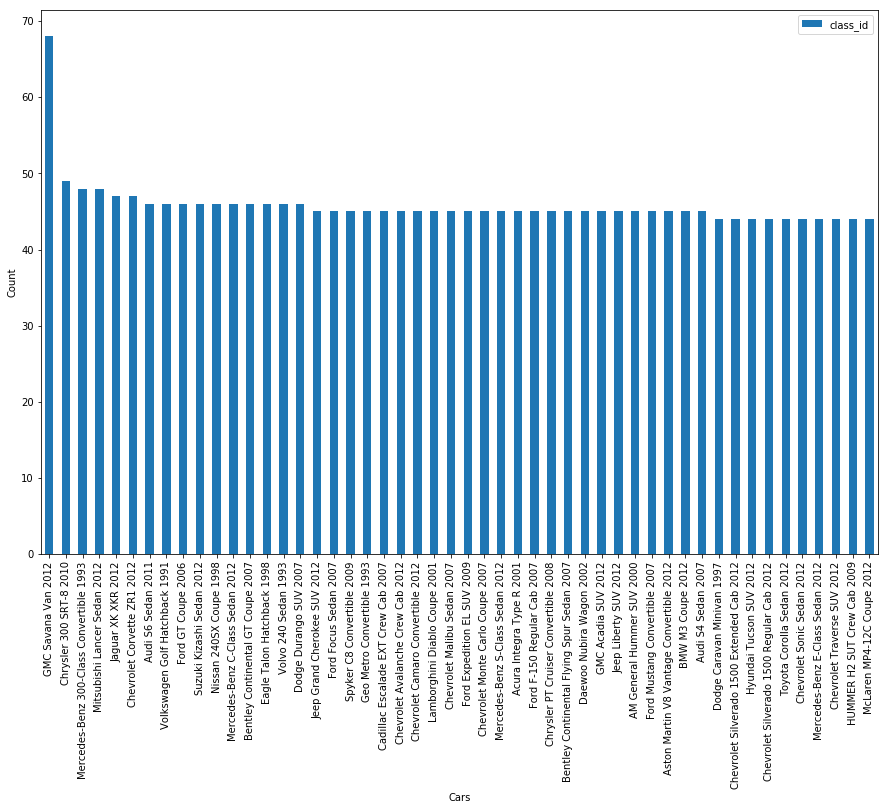

In [16]:
freq_labels.head(50).plot.bar(figsize=(15,10))
plt.xticks(rotation=90);
plt.xlabel("Cars");
plt.ylabel("Count");

In [17]:
from collections import Counter

print('The data set is imbalanced: {}'.format(Counter(df_train['class_id'])))

The data set is imbalanced: Counter({118: 68, 78: 49, 166: 48, 160: 48, 143: 47, 55: 47, 193: 46, 190: 46, 42: 46, 19: 46, 111: 46, 161: 46, 170: 46, 181: 46, 97: 46, 94: 46, 122: 45, 72: 45, 147: 45, 52: 45, 43: 45, 64: 45, 113: 45, 7: 45, 58: 45, 164: 45, 120: 45, 146: 45, 108: 45, 178: 45, 23: 45, 0: 45, 5: 45, 71: 45, 106: 45, 152: 45, 114: 45, 80: 45, 33: 45, 81: 45, 88: 44, 57: 44, 84: 44, 171: 44, 169: 44, 104: 44, 176: 44, 172: 44, 186: 44, 93: 44, 187: 44, 144: 44, 73: 44, 136: 44, 75: 44, 107: 44, 124: 44, 159: 44, 15: 44, 62: 44, 131: 44, 30: 44, 45: 44, 150: 44, 86: 44, 74: 44, 163: 44, 13: 43, 2: 43, 191: 43, 119: 43, 85: 43, 179: 43, 153: 43, 138: 43, 103: 43, 14: 43, 189: 43, 28: 43, 109: 43, 17: 43, 50: 43, 60: 43, 154: 43, 148: 43, 47: 43, 194: 43, 21: 43, 112: 43, 116: 43, 69: 43, 145: 43, 79: 43, 105: 42, 134: 42, 192: 42, 65: 42, 132: 42, 96: 42, 100: 42, 110: 42, 125: 42, 130: 42, 177: 42, 139: 42, 29: 42, 49: 42, 182: 42, 83: 42, 167: 42, 20: 42, 31: 42, 3: 42, 11

It can be seen that:
    
    - Label samples are biased to some labels.
    - Balancing weight for each class may improve LB score.

In [18]:
from sklearn.utils.class_weight import compute_class_weight

#y_integers = np.argmax(y_train1, axis=1)
class_weights = compute_class_weight('balanced', np.unique(df_train['class_id']), df_train['class_id'])
class_weights = dict(enumerate(class_weights))

## 2.3 Feature Extraction

### Extract Bottleneck Features for Train and Test Data


As metioned before, every model have their own types of data. Therefore, different data are created for each model.
Function from [Yang Peiwan's kernel](https://www.kaggle.com/yangpeiwen/keras-inception-xception-0-47) with modifications:

In [19]:
def get_features(MODEL, data, batch_size, preprocess):
    
    cnn_model = MODEL(include_top=False, input_shape=(im_width, im_heigth, im_chan), weights='imagenet')
    
    inputs = Input((im_width, im_heigth, im_chan))
    x = inputs
    x = Lambda(preprocess, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=batch_size, verbose=0)
    return features### InceptionV3

### InceptionV3

In [20]:
X_train_inception = get_features(InceptionV3, x_imgs, 32, inception_v3_pre)
X_valid_inception = get_features(InceptionV3, x_valid, 32, inception_v3_pre)
X_test_inception = get_features(InceptionV3, x_test, 32, inception_v3_pre)

### Xception

In [21]:
X_train_xception = get_features(Xception, x_imgs, 32, xception_pre)
X_valid_xception = get_features(Xception, x_valid, 32, xception_pre)
X_test_xception = get_features(Xception, x_test, 32, xception_pre)

### Resnet50

In [22]:
X_train_resnet = get_features(ResNet50, x_imgs, 32, resnet50_pre)
X_valid_resnet = get_features(ResNet50, x_valid, 32, resnet50_pre)
X_test_resnet = get_features(ResNet50, x_test, 32, resnet50_pre)

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


### InceptionResNetV2

In [23]:
X_train_inceptionresnet = get_features(InceptionResNetV2, x_imgs, 32, InceptionResNetV2_pre)
X_valid_inceptionresnet = get_features(InceptionResNetV2, x_valid, 32, InceptionResNetV2_pre)
X_test_inceptionresnet = get_features(InceptionResNetV2, x_test, 32, InceptionResNetV2_pre)

In [44]:
X_test_inceptionresnet.shape[0]

4825

### VGG19

In [25]:
X_train_vgg = get_features(VGG19, x_imgs, 32, vgg19_pre)
X_valid_vgg = get_features(VGG19, x_valid, 32, vgg19_pre)
X_test_vgg = get_features(VGG19, x_test, 32, vgg19_pre)

# 3. Training/Validating Pipeline

## 3.1. Split Test/Valid dataset

### Split test data for model validation and testing, with 40% validation and 60% testing

In [60]:
#Converting Y into one-hot-encoding

from keras.utils import to_categorical

y_train = to_categorical(df_train['class_id'])
y_test = to_categorical(y_test)
y_valid = to_categorical(y_valid)

In [61]:
print("x train shape :", X_train_xception.shape[0])
print("x valid shape :", X_valid_xception.shape[0])
print("x test shape :", X_test_xception.shape[0])
print("y train shape :", y_train.shape[0])
print("y valid shape :", y_valid.shape[0])
print("y train shape :", y_test.shape[0])

x train shape : 8144
x valid shape : 3216
x test shape : 4825
y train shape : 8144
y valid shape : 3216
y train shape : 4825


## If you want to Test the trained model, skip 3.2 and move to 3.4

Since I provided the trained model for all Inception, Xception, VGG19, Resnet50, InceptionResnet, and the Ensemble Model. You can skip this part. All the save model are in folder save_models

## 3.2. Classifiers


### Neural Net

In [63]:
n_class = 196

Inception_model = Sequential()
Inception_model.add(Dense(512, activation='relu', input_shape=X_train_inception.shape[1:]))
Inception_model.add(Dropout(0.2))
Inception_model.add(Dense(n_class, activation='softmax'))

Inception_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'],
           )

Inception_model.summary()


Xception_model = Sequential()
Xception_model.add(Dense(512, activation='relu', input_shape=X_train_xception.shape[1:]))
Xception_model.add(Dropout(0.2))
Xception_model.add(Dense(n_class, activation='softmax'))

Xception_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'],
           )

Xception_model.summary()


VGG_model = Sequential()
VGG_model.add(Dense(512, activation='relu', input_shape=X_train_vgg.shape[1:]))
VGG_model.add(Dropout(0.2))
VGG_model.add(Dense(n_class, activation='softmax'))

VGG_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'], 
           )

VGG_model.summary()

Resnet_model = Sequential()
Resnet_model.add(Dense(512, activation='relu', input_shape=X_train_resnet.shape[1:]))
Resnet_model.add(Dropout(0.2))
Resnet_model.add(Dense(n_class, activation='softmax'))

Resnet_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'],
           )

Resnet_model.summary()

InceptionResnet_model = Sequential()
InceptionResnet_model.add(Dense(512, activation='relu', input_shape=X_train_inceptionresnet.shape[1:]))
InceptionResnet_model.add(Dropout(0.2))
InceptionResnet_model.add(Dense(n_class, activation='softmax'))

InceptionResnet_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'],
           )

InceptionResnet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 196)               100548    
Total params: 1,149,636
Trainable params: 1,149,636
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________


### Callbacks

- ModelCheckpoint is used to get the best model after epochs

- ReduceLROnPlateau is used to manipulate learning rate for more delciate correction

- EarlyStopping stop the model if there is no improvement to validation loss. 

Callbacks funtion is used to avoid model overfit and wasting time.

In [64]:
early_stopping = EarlyStopping(monitor='val_loss', mode = 'min',patience=100, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode = 'min',factor=0.5, patience=50, min_lr=0.00001, verbose=1)

inception_callbacks=[TQDMNotebookCallback(),
                     reduce_lr,
                      ModelCheckpoint(filepath='saved_models/inception.best.from_features.hdf5', 
                               verbose=0, save_best_only=True),
                     early_stopping
                     ]

xception_callbacks=[TQDMNotebookCallback(),
                    reduce_lr,
                      ModelCheckpoint(filepath='saved_models/xception.best.from_features.hdf5', 
                               verbose=0, save_best_only=True),
                    early_stopping
                     ]

resnet_callbacks=[TQDMNotebookCallback(),
                    reduce_lr,
                    ModelCheckpoint(filepath='saved_models/resnet.best.from_features.hdf5', 
                               verbose=0, save_best_only=True),
                  early_stopping
                     ]

vgg_callbacks=[TQDMNotebookCallback(),
                reduce_lr,
                ModelCheckpoint(filepath='saved_models/vgg.best.from_features.hdf5', 
                               verbose=0, save_best_only=True),
               early_stopping
                     ]

inceptionresnet_callbacks=[TQDMNotebookCallback(),
                reduce_lr,
                ModelCheckpoint(filepath='saved_models/inceptionresnet.best.from_features.hdf5', 
                               verbose=0, save_best_only=True),
               early_stopping
                     ]

In [65]:
epochs = 1000 # Increase this if you want more accurate results(It is recommended to run on personal computer in this case)

inception_history = Inception_model.fit(X_train_inception, y_train, 
          validation_data=(X_valid_inception, y_valid),
          epochs=epochs, 
          callbacks=inception_callbacks,
          class_weight=class_weights,
          batch_size=32, verbose=0)

xception_history = Xception_model.fit(X_train_xception, y_train, 
          validation_data=(X_valid_xception, y_valid),
          epochs=epochs,                            
          callbacks=xception_callbacks,
          class_weight=class_weights,
          batch_size=32, verbose=0)

resnet_history = Resnet_model.fit(X_train_resnet, y_train, 
          validation_data=(X_valid_resnet, y_valid),
          epochs=epochs, 
          callbacks=resnet_callbacks,
          class_weight=class_weights,
          batch_size=32, verbose=0)

vgg_history = VGG_model.fit(X_train_vgg, y_train, 
          validation_data=(X_valid_vgg, y_valid),
          epochs=epochs, 
          callbacks=vgg_callbacks,
          class_weight=class_weights,
          batch_size=32, verbose=0)

inceptionresnet_history = InceptionResnet_model.fit(X_train_inceptionresnet, y_train, 
                        validation_data=(X_valid_inceptionresnet, y_valid),
                        epochs=epochs, 
                        callbacks=inceptionresnet_callbacks,
                        class_weight=class_weights,
                        batch_size=32, verbose=0)


Epoch 00073: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 00123: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00123: early stopping



Epoch 00064: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 00114: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00114: early stopping



Epoch 00066: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 00116: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00116: early stopping



Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 00109: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00109: early stopping



Epoch 00074: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 00124: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00124: early stopping


 ## 3.3 Models Evaluation

### Learning Curve

Learning rate is the step by which the optimizer walks through the 'loss landscape'. The higher it is, the bigger are the steps and the quicker is the convergence. However, the sampling is very poor with an high LR and the optimizer could probably fall into a local minima. Low learning rate shows slower convergence and lower chance of falling into a local minima, but it leads to underfitting and requires more epochs.
To detect this, learning curve plot is used. 

In [66]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss
def model_evaluation(history):
    
    index_acc = np.argmax(history.history["acc"])
    acc = history.history["acc"][index_acc]
    index_val_acc = np.argmax(history.history["val_acc"])
    val_acc = history.history["val_acc"][index_val_acc]

    index_loss = np.argmin(history.history["loss"])
    losses = history.history["loss"][index_loss]
    index_val_loss = np.argmin(history.history["val_loss"])
    val_losses = history.history["val_loss"][index_val_loss]

    acc_saved = history.history["acc"][index_val_loss]
    val_acc_saved = history.history["val_acc"][index_val_loss]
    train_loss_saved = losses = history.history["loss"][index_val_loss]

    print("best train accuracy {} on epoch {} ".format(acc, index_acc+1))
    print("best validation accuracy {} on epoch {} ".format(val_acc, index_val_acc+1))
    print("lowest train loss {} on epoch {} ".format(losses, index_loss+1))
    print("lowest validation loss {} on epoch {} ".format(val_losses, index_val_loss+1))
    print("saved accuracy : {}, val accuracy : {}, and train loss {} : ".format(acc_saved, val_acc_saved, train_loss_saved))

    # Plot the loss and accuracy curves for training and validation on InceptionV3
    fig, ax = plt.subplots(2,1)
    ax[0].plot(history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
    ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)

## Inception

best train accuracy 0.9807220039292731 on epoch 123 
best validation accuracy 0.46548507462686567 on epoch 86 
lowest train loss 0.8378634872043063 on epoch 122 
lowest validation loss 2.172108376204078 on epoch 23 
saved accuracy : 0.7491404715127702, val accuracy : 0.43656716417910446, and train loss 0.8378634872043063 : 


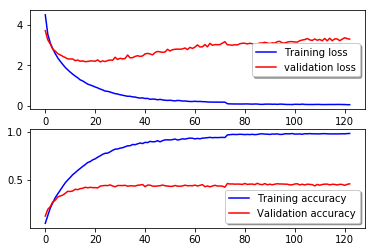

In [68]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss
model_evaluation(inception_history)

## Xception

best train accuracy 0.9965618860510805 on epoch 68 
best validation accuracy 0.5099502487562189 on epoch 67 
lowest train loss 0.7728557256443795 on epoch 68 
lowest validation loss 2.089953342480446 on epoch 14 
saved accuracy : 0.7868369351669942, val accuracy : 0.46828358208955223, and train loss 0.7728557256443795 : 


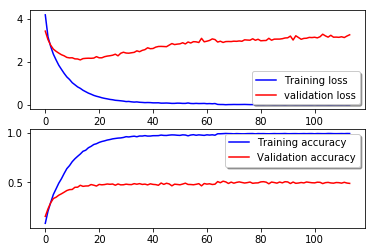

In [69]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss
model_evaluation(xception_history)

## Resnet50

best train accuracy 0.9945972495088409 on epoch 108 
best validation accuracy 0.5842661691542289 on epoch 75 
lowest train loss 0.45374462564708207 on epoch 108 
lowest validation loss 1.6924319658706437 on epoch 16 
saved accuracy : 0.8727897838899804, val accuracy : 0.5537935323383084, and train loss 0.45374462564708207 : 


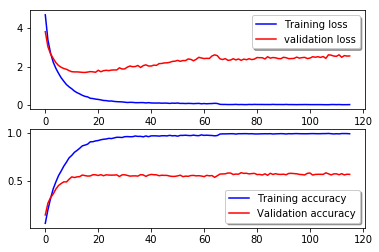

In [70]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss
model_evaluation(resnet_history)

## VGG19

best train accuracy 0.9910363457760314 on epoch 94 
best validation accuracy 0.5205223880597015 on epoch 64 
lowest train loss 0.7928222700045947 on epoch 95 
lowest validation loss 2.055707364533078 on epoch 9 
saved accuracy : 0.762278978388998, val accuracy : 0.49191542288557216, and train loss 0.7928222700045947 : 


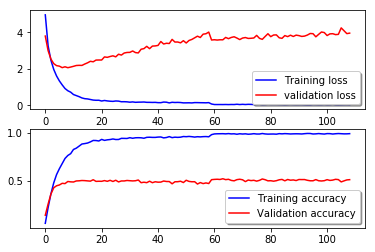

In [71]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss
model_evaluation(vgg_history)

## InceptionResnet_V2

best train accuracy 0.9792485265225933 on epoch 123 
best validation accuracy 0.5003109452736318 on epoch 109 
lowest train loss 1.0133025969409755 on epoch 123 
lowest validation loss 2.2136144709231247 on epoch 24 
saved accuracy : 0.6980599214145383, val accuracy : 0.4319029850746269, and train loss 1.0133025969409755 : 


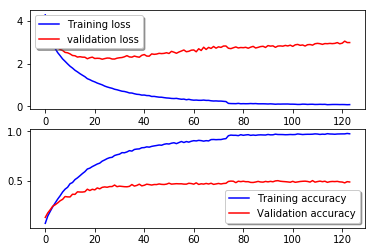

In [72]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss
model_evaluation(inceptionresnet_history)

# 3.4 Ensemble models

After fitting and eevaluating the models, now we ensemble all the models. 

### Load models with the highest accuracy results

In [73]:
from keras.models import load_model

inception_best = 'saved_models/inception.best.from_features.hdf5'
xception_best = 'saved_models/xception.best.from_features.hdf5'
resnet_best = 'saved_models/resnet.best.from_features.hdf5'
vgg_best = 'saved_models/vgg.best.from_features.hdf5'
inceptionresnet_best = 'saved_models/inceptionresnet.best.from_features.hdf5'

### Create Data sets for Ensemble model

In [74]:
incept = load_model(inception_best)
xcept = load_model(xception_best)
rest = load_model(resnet_best)
vg = load_model(vgg_best)
incres = load_model(inceptionresnet_best)

In [75]:
inc = incept.predict(X_train_inception, batch_size=32, verbose=0)
xce = xcept.predict(X_train_xception, batch_size=32, verbose=0)
res = rest.predict(X_train_resnet, batch_size=32, verbose=0)
vgg = vg.predict(X_train_vgg, batch_size=32, verbose=0)
incs = incres.predict(X_train_inceptionresnet, batch_size=32, verbose=0)


ensemble_train_features = np.concatenate((inc,xce,res,vgg,incs), axis = 1)

In [76]:
inc = incept.predict(X_valid_inception, batch_size=32, verbose=0)
xce = xcept.predict(X_valid_xception, batch_size=32, verbose=0)
res = rest.predict(X_valid_resnet, batch_size=32, verbose=0)
vgg = vg.predict(X_valid_vgg, batch_size=32, verbose=0)
incs = incres.predict(X_valid_inceptionresnet, batch_size=32, verbose=0)


ensemble_valid_features = np.concatenate((inc,xce,res,vgg,incs), axis = 1)

In [77]:
inc = incept.predict(X_test_inception, batch_size=32, verbose=0)
xce = xcept.predict(X_test_xception, batch_size=32, verbose=0)
res = rest.predict(X_test_resnet, batch_size=32, verbose=0)
vgg = vg.predict(X_test_vgg, batch_size=32, verbose=0)
incs = incres.predict(X_test_inceptionresnet, batch_size=32, verbose=0)


ensemble_test_features = np.concatenate((inc,xce,res,vgg,incs), axis = 1)

In [79]:
print("Train shape: {}, validation shape: {}, test shape: {}".format(ensemble_train_features.shape, ensemble_valid_features.shape, ensemble_test_features.shape))

Train shape: (8144, 980), validation shape: (3216, 980), test shape: (4825, 980)


## If you want to test the ensemble model, skip this training part below and move to Section 4

In [81]:
ensemble_model = Sequential()
ensemble_model.add(Dense(1024, activation='relu', input_shape= ensemble_train_features.shape[1:]))
ensemble_model.add(Dropout(0.5))
ensemble_model.add(Dense(512, activation='relu'))
ensemble_model.add(Dropout(0.2))
ensemble_model.add(Dense(n_class, activation='softmax'))

ensemble_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'],
           )

ensemble_model.summary()

ensemble_callbacks=[TQDMNotebookCallback(),
                     reduce_lr,
                      ModelCheckpoint(filepath='saved_models/ensemble.best.from_features.hdf5', 
                               verbose=0, save_best_only=True),
                     early_stopping
                     ]

ensemble_history = ensemble_model.fit(ensemble_train_features, y_train, 
                        validation_data=(ensemble_valid_features, y_valid),
                        epochs=1000, 
                        callbacks=ensemble_callbacks,
                        class_weight=class_weights,
                        batch_size=32, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 1024)              1004544   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 196)               100548    
Total params: 1,629,892
Trainable params: 1,629,892
Non-trainable params: 0
_________________________________________________________________



Epoch 00052: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00102: early stopping


best train accuracy 0.9986493123772102 on epoch 90 
best validation accuracy 0.6685323383084577 on epoch 8 
lowest train loss 0.04616980701739843 on epoch 101 
lowest validation loss 1.5334711157860448 on epoch 2 
saved accuracy : 0.9916502946954814, val accuracy : 0.6610696517412935, and train loss 0.04616980701739843 : 


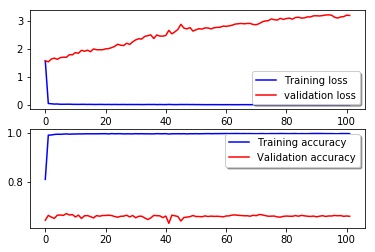

In [82]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss
model_evaluation(ensemble_history)

# 4. Testing model's performance

## 4.1 Confusion Matrix, Precision-Recall, AUC ROC Curve

Confusion matrix can check false positives for each labels. This can visualize bias and variance of the model's prediction.

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned. See [HERE](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html) for more info.

I validate the models using Test data.

In [83]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [84]:
def test_model(model_name, X_test, Y_test):

    # Look at confusion matrix 

    # Predict the values from the validation dataset
    Y_pred = model_name.predict(X_test)
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(Y_test,axis = 1) 
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    # plot the confusion matrix
    ax = sns.heatmap(confusion_mtx)

    #Calculating Precision-Recall Score

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(196):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        Y_pred[:, i])
        average_precision[i] = average_precision_score(Y_test[:, i], Y_pred[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
        Y_pred.ravel())
    average_precision["micro"] = average_precision_score(Y_test, Y_pred,
                                                     average="micro")

    print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))

    #Calculating ROC AUC Score

    roc_score = roc_auc_score(Y_test, Y_pred)

    print("ROC AUC Score: ", roc_score)
    
    #calculating test accuracy
    
    acc_score = accuracy_score(Y_true, Y_pred_classes)
    
    print("Test accuracy: {}".format(acc_score))

### InceptionV3

Average precision score, micro-averaged over all classes: 0.45
ROC AUC Score:  0.9791621064501954
Test accuracy: 0.43357512953367877


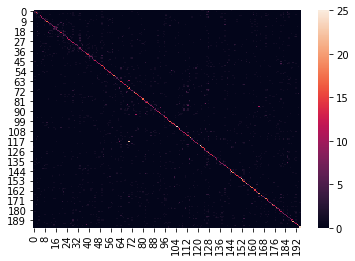

In [85]:
test_model(incept, X_test_inception, y_test)

### Xception

Average precision score, micro-averaged over all classes: 0.50
ROC AUC Score:  0.9821938201779914
Test accuracy: 0.482279792746114


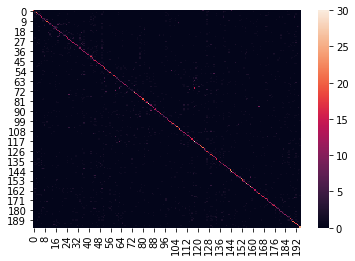

In [86]:
test_model(xcept, X_test_xception, y_test)

### Resnet50

Average precision score, micro-averaged over all classes: 0.59
ROC AUC Score:  0.9868168753085338
Test accuracy: 0.5490155440414508


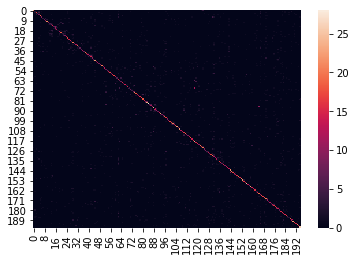

In [87]:
test_model(rest, X_test_resnet, y_test)

### VGG19

Average precision score, micro-averaged over all classes: 0.50
ROC AUC Score:  0.9806038913605954
Test accuracy: 0.4752331606217617


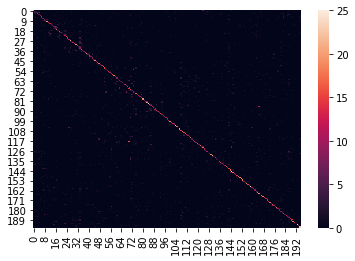

In [88]:
test_model(vg, X_test_vgg, y_test)

## InceptionResnetV2

Average precision score, micro-averaged over all classes: 0.43
ROC AUC Score:  0.9774472682673846
Test accuracy: 0.43316062176165804


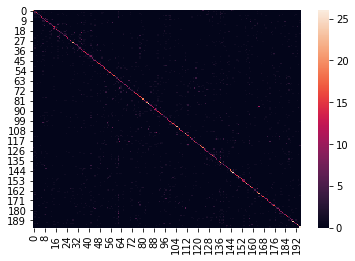

In [89]:
test_model(incres, X_test_inceptionresnet, y_test)

## Ensemble Model - The Final Model

In [90]:
# Load best saved model for ensemble model

ensemble = load_model("saved_models/ensemble.best.from_features.hdf5")

Average precision score, micro-averaged over all classes: 0.71
ROC AUC Score:  0.9799981277257861
Test accuracy: 0.6654922279792747


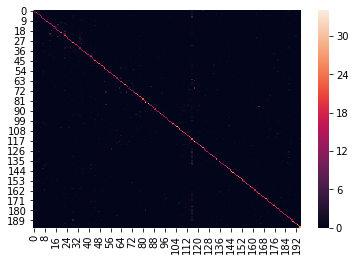

In [91]:
test_model(ensemble, ensemble_test_features, y_test)

In [112]:
y_ens = ensemble.predict(ensemble_test_features)

## Lets check the model with images and labels...

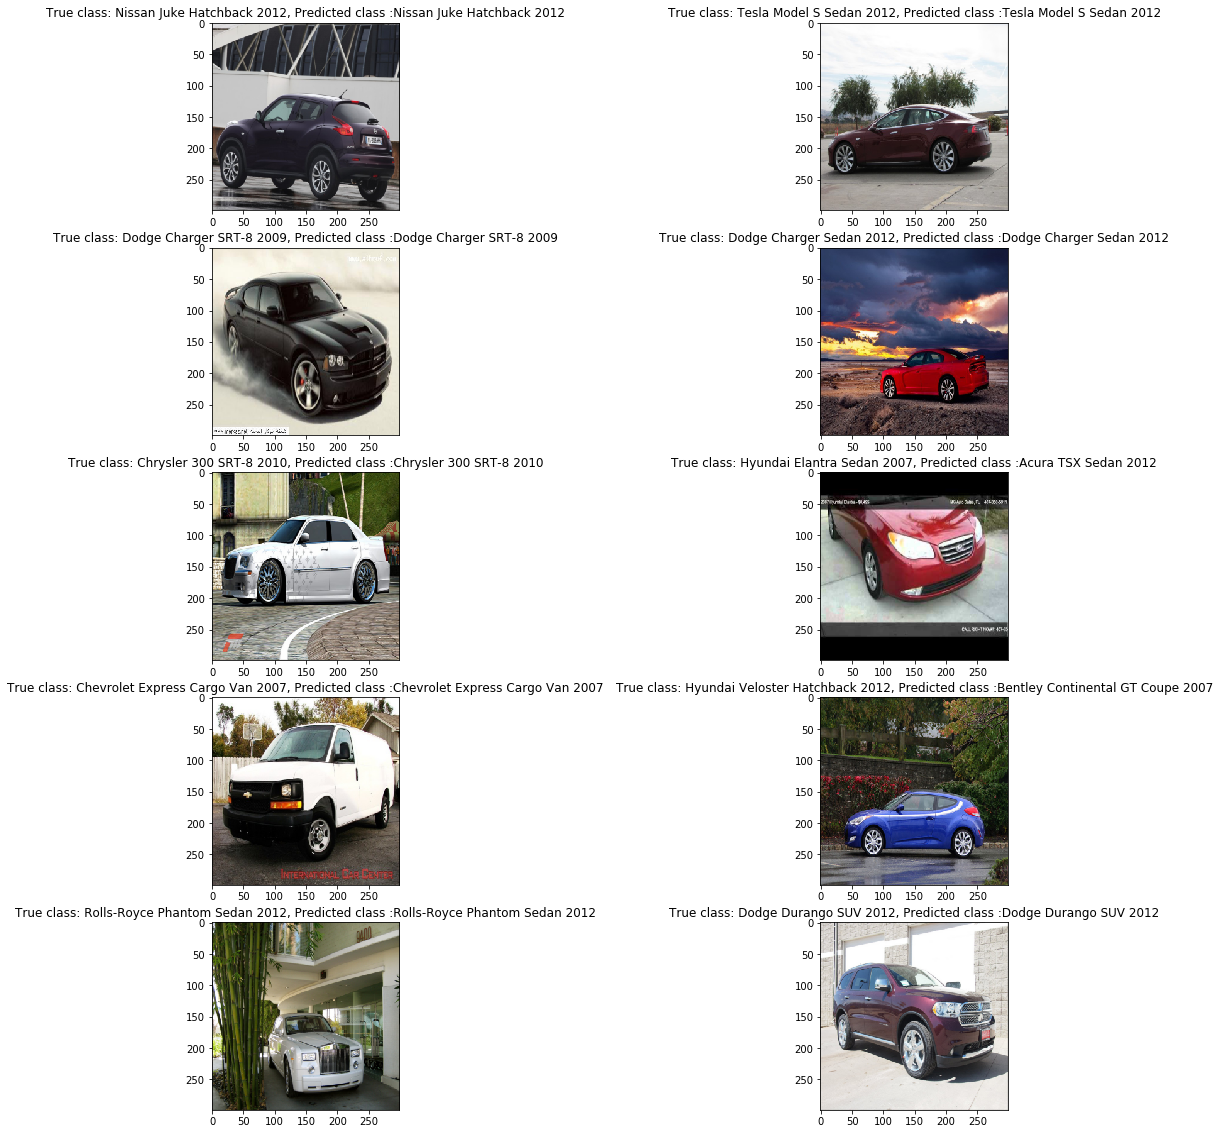

In [120]:
length = y_ens.shape[0]
rand= np.random.randint(0,length,20)

fig=plt.figure(figsize=(20, 20))
columns = 2
rows = 5
for i in range(1, columns*rows +1):
        r = rand[i-1]
        img = x_test[r]
        y_id = np.argmax(y_test[r])
        cla_name = df_train1['names'][y_id]
        pred_id = np.argmax(y_ens[r])
        pred_name = df_train1['names'][pred_id]
        fig.add_subplot(rows, columns, i)
        plt.title("True class: " + cla_name + ", Predicted class :" + pred_name)
        plt.imshow(img)

plt.show()

## 4.2 Results Summary

The results can be slightly change if we re-train the model

#### 1. Inception

*Classification Accuracy: 0.6966 (train), 0.4229 (validation)

*Loss error             : 1.2172 (train), 2.1878 (validation)

*Average precision score, micro-averaged over all classes: 0.44

*ROC AUC Score:  0.9790820458637852

#### 2. Xception

*Classification Accuracy: 0.8115 (train), 0.4652 (validation)

*Loss error             : 0.6989 (train), 2.1083 (validation)

*Average precision score, micro-averaged over all classes: 0.50

*ROC AUC Score:  0.9824882943932024

#### 3. Resnet50

*Classification Accuracy: 0.8886 (train), 0.5572 (validation)

*Loss error             : 0.4049 (train), 1.7131 (validation)

*Average precision score, micro-averaged over all classes: 0.59

*ROC AUC Score:  0.9869771002900094

#### 4. VGG19

*Classification Accuracy: 0.7349 (train), 0.4773 (validation)

*Loss error             : 0.8825 (train), 2.1087 (validation)

*Average precision score, micro-averaged over all classes: 0.48

*ROC AUC Score:  0.9796499374539075

#### 5. InceptionResnet

*Classification Accuracy: 0.6971 (train), 0.4344 (validation)

*Loss error             : 1.0177 (train), 2.2085 (validation)

*Average precision score, micro-averaged over all classes: 0.44

*ROC AUC Score:  0.9774902336172602

### 6. Ensemble Model

*Classification Accuracy: 0.9905 (train), 0.6576 (validation)

*Loss error             : 0.0490 (train), 1.5401 (validation)

*Average precision score, micro-averaged over all classes: 0.70

*ROC AUC Score:  0.9813272164290486




It shows that Ensemble Model obtained significant improvement over others